# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* NFWCluster deflector class: a NFW halo and EPL subhalos
* Integration with Lens interface to simulate lens related quanities.
* Use cluster catalog to build a cluster lens population
* Generate a cluster lens population with LensPop

Not yet implemented:
* Realistic halo population based on halo mass distribution instead of catalogs

## Setup

In [1]:
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors

from slsim.lens_pop import LensPop

from slsim.Plots.lens_plots import LensingPlots

import numpy as np
import matplotlib.pyplot as plt
from astropy.units import Quantity
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

Generate a population of sources and red galaxies to be used as cluster members

In [2]:
np.random.seed(1)

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

sky_area = Quantity(value=0.05, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.2, "z_max": 1.0}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.21, "z_max": 5.0}

galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=sky_area,
    filters=None,
)
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

Load a cluster catalog. This is an example of a few clusters from redMaPPer

In [4]:
cluster_catalog = Table.read("../data/redMaPPer/clusters_example.fits")
members_catalog = Table.read("../data/redMaPPer/members_example.fits")

Cluster has redshift and richness. A NFW halo is used to describe its mass based on a mass-richness relation.

In [5]:
cluster_catalog[:3]

cluster_id,richness,z
int16,float32,float32
266,44.300,0.7447
356,33.640,0.4202
217,53.090,0.4392


We use real members to distribute the subhalos. To each member we assign a SkyPyPipeline red galaxy based on magnitudes and redshift to build EPL subhalos.

In [6]:
members_catalog[:3]

cluster_id,member_id,ra,dec,mag_g,mag_r,mag_i,mag_z
int16,int64,float64,float64,float32,float32,float32,float32
7,2929088686,70.210811,-47.799704,21.844,20.710,20.279,20.009
7,2929089143,70.247586,-47.796759,21.624,20.060,19.578,19.279
7,2929089918,70.186850,-47.786768,22.167,20.746,20.302,20.026


In [7]:
lens_clusters = deflectors.ClusterCatalogLens(
        cluster_list=cluster_catalog,
        members_list=members_catalog,
        galaxy_list=galaxy_simulation_pipeline.red_galaxies,
        kwargs_cut=kwargs_deflector_cut,
        kwargs_mass2light={},
        cosmo=cosmo,
        sky_area=sky_area,
    )

In [8]:
lenspop = LensPop(
    deflector_population=lens_clusters,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

## Generate images of random lenses

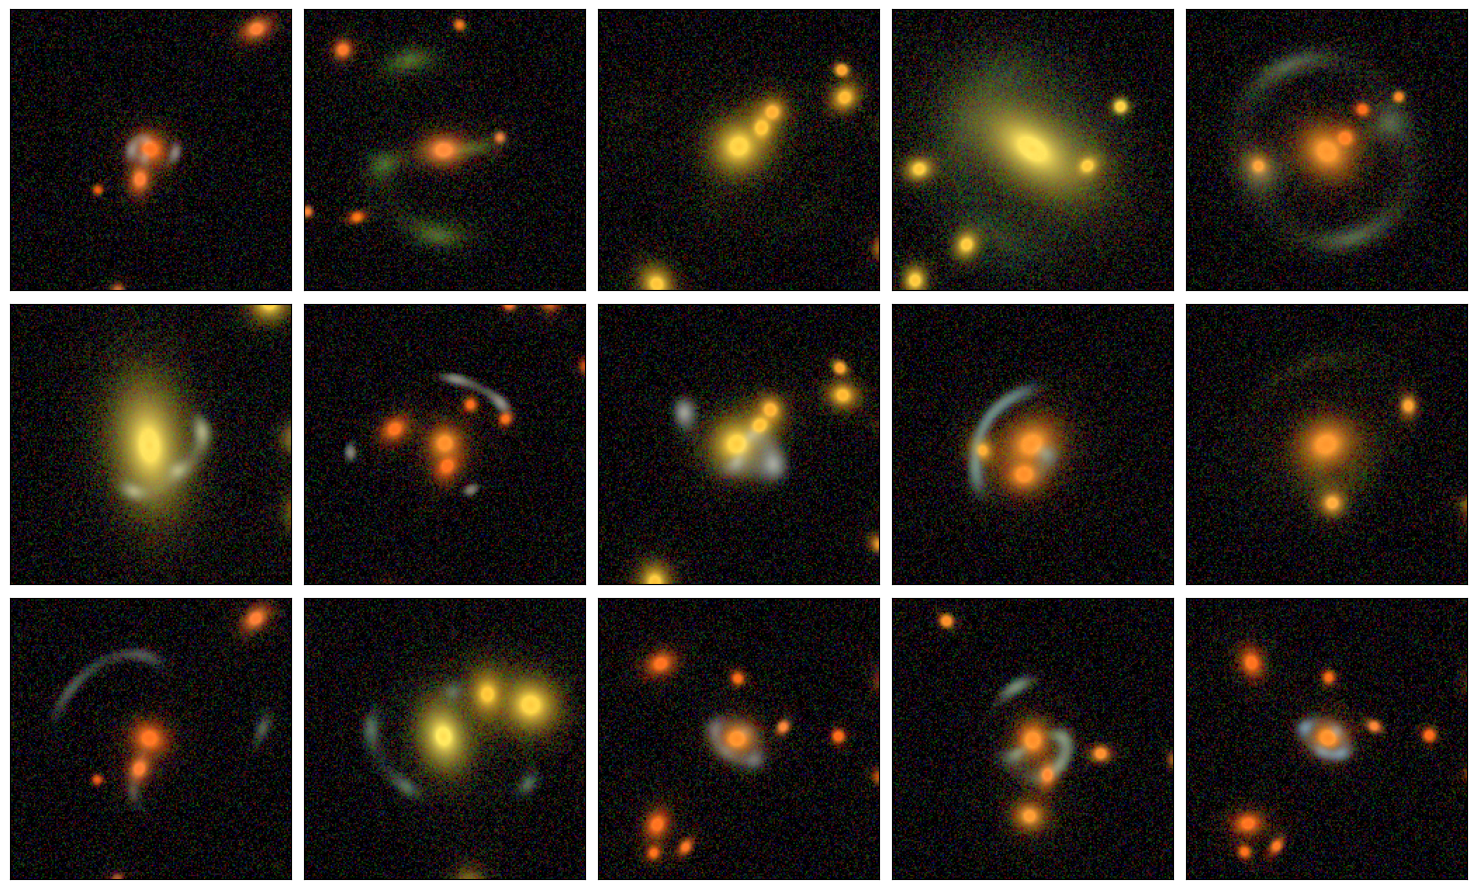

In [9]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 2.0,
    "max_image_separation": 30.0,
    "mag_arc_limit": {"g": 22, "r": 22, "i": 22},
}

cluster_lens_plot = LensingPlots(lenspop, num_pix=200, coadd_years=10)

# generate montage indicating which bands are used for the rgb color image
fig, axes = cluster_lens_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=3,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()